In [18]:
import os
import json
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

path = "training_data"
subjects = [s for s in os.listdir(path) if s.startswith('sub')]

for subj in subjects:
    func_path = os.path.join(path, subj, "func")
    
    echo_images = []
    echo_times = []

    # Load 4 echo images and their TE values
    for echo_file in sorted(os.listdir(func_path)):
        if echo_file.endswith('.nii.gz') and 'echo-' in echo_file:
            # Load image
            img_path = os.path.join(func_path, echo_file)
            img = sitk.ReadImage(img_path, sitk.sitkFloat32)
            img_arr = sitk.GetArrayFromImage(img)  

            # Reduce to 3D by averaging over time dimension (first axis)
            img_arr_3d = np.mean(img_arr, axis=0) 
            echo_images.append(img_arr_3d)

            # Load TE from JSON
            json_path = img_path.replace('.nii.gz', '.json')
            with open(json_path, 'r') as f:
                meta = json.load(f)
                echo_times.append(meta['EchoTime'])

    # Stack echoes along first axis: (num_echoes, z, y, x)
    echo_images = np.stack(echo_images, axis=0)
    echo_times = np.array(echo_times)

    E, Z, Y, X = echo_images.shape
    num_voxels = Z * Y * X

    # Mask zero/negative voxels
    mask = echo_images > 0
    safe_images = np.where(mask, echo_images, 1)  # replace zeros with 1 for log
    log_images = np.log(safe_images)

    # Reshape to (num_echoes, num_voxels)
    Y_matrix = log_images.reshape(E, num_voxels)

    # Linear regression setup: X matrix (E x 2)
    X_matrix = np.vstack([np.ones(E), echo_times]).T
    XtX_inv = np.linalg.inv(X_matrix.T @ X_matrix)
    Xt = X_matrix.T

    # Solve theta for all voxels at once: theta = (a, b)
    theta = XtX_inv @ Xt @ Y_matrix  # shape: (2, num_voxels)
    a = theta[0]
    b = theta[1]

    # Recover T1rho and T2*
    A_map = np.exp(a).reshape(Z, Y, X)
    T2star_map = np.zeros_like(b)
    valid = b != 0
    T2star_map[valid] = -1 / b[valid]
    T2star_map = T2star_map.reshape(Z, Y, X)

    # Mask voxels with zero signal in all echoes for invalid voxels
    invalid_voxels = np.all(~mask, axis=0)
    A_map[invalid_voxels] = 0
    T2star_map[invalid_voxels] = 0

    # Convert to SimpleITK images 
    A_img = sitk.GetImageFromArray(A_map)
    T2star_img = sitk.GetImageFromArray(T2star_map)

    # Save outputs
    sitk.WriteImage(A_img, os.path.join(func_path, 'A_map.nii.gz'))
    sitk.WriteImage(T2star_img, os.path.join(func_path, 'T2star_map.nii.gz'))

    print(f"Processed subject {subj}")


Processed subject sub-20950
Processed subject sub-21281
Processed subject sub-20863
Processed subject sub-21124
Processed subject sub-04620
Processed subject sub-11310
Processed subject sub-21384
Processed subject sub-21116
Processed subject sub-21270
Processed subject sub-21260
Processed subject sub-19774
Processed subject sub-20851
Processed subject sub-21273
Processed subject sub-21456
Processed subject sub-21611
Processed subject sub-21452
Processed subject sub-21304
Processed subject sub-16053
Processed subject sub-21126
Processed subject sub-21317
Processed subject sub-21300
Processed subject sub-20494
Processed subject sub-19979
Processed subject sub-20824
Processed subject sub-20932
Processed subject sub-21256
Processed subject sub-04570
Processed subject sub-20892
Processed subject sub-20094
Processed subject sub-20847
Processed subject sub-20976
Processed subject sub-21324
Processed subject sub-20893
Processed subject sub-21252
Processed subject sub-20503
Processed subject su

In [20]:
print(img_arr.shape)
print(echo_images.shape)


(239, 30, 64, 64)
(4, 30, 64, 64)


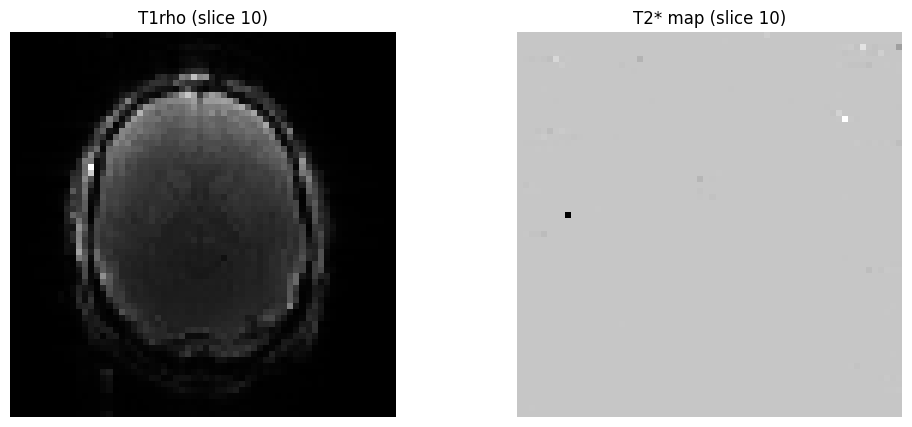

In [24]:
slice_idx = 10

# Display T1rho map
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(A_map[slice_idx, :, :], cmap='gray')
plt.title(f"T1rho (slice {slice_idx})")
plt.axis('off')

# Display T2* map
plt.subplot(1, 2, 2)
plt.imshow(T2star_map[slice_idx, :, :], cmap='gray')
plt.title(f"T2* map (slice {slice_idx})")
plt.axis('off')

plt.show()


In [23]:
A_map[slice_idx, :, :]

array([[ 0.        , 11.61059775, 11.47110915, ...,  9.8111472 ,
         9.95411889, 10.56293194],
       [ 0.        ,  9.60418004,  9.3827632 , ...,  9.89488138,
        10.03179751, 10.38070051],
       [ 0.        , 10.89948033, 11.32831503, ...,  8.79544075,
         8.98257425,  9.29558931],
       ...,
       [ 0.        , 11.53462158, 12.34482499, ..., 11.69038028,
        11.37189179, 12.43294414],
       [ 0.        ,  9.1256093 ,  8.91361111, ...,  9.35814946,
         9.546735  ,  9.61033308],
       [ 0.        , 12.12025461, 12.03951449, ..., 13.59008857,
        13.65304898, 15.09264091]])